In [1]:
import pandas as pd
import glob
from urllib.parse import urlparse
import more_itertools as mit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import gmtime, strftime
import validators

In [2]:
! pip install -e ../..

Obtaining file:///home/didi/Documents/fake-image-detection
  Found existing installation: src 0.0.1
    Uninstalling src-0.0.1:
      Successfully uninstalled src-0.0.1
  Running setup.py develop for src


In [3]:
import autoreload
%load_ext autoreload
%autoreload 2

In [5]:
from src.features.url_classification import classifier_LICA, classifier_DFR

In [6]:
lica_clf = classifier_LICA.LICA()
dfr_clf = classifier_DFR.DFR()

In [8]:
def clean_url(url):
    return urlparse(url).netloc.replace('www.', '')

In [75]:
DIR = '../../data/external'
data_xls = pd.read_excel('{}/MBFC Annotations.xlsx'.format(DIR), 'new_merged', index_col=None)
data_xls.drop(data_xls[data_xls.is_factual.isna()].index, inplace=True)
data_xls.is_factual = data_xls.is_factual.astype(str).str.upper()
data_xls['(NEW) url'] = data_xls['(NEW) url'].map(lambda x: clean_url(x))

In [91]:
url_dict = dict(zip(data_xls['(NEW) url'], data_xls.is_factual))

In [92]:
def fix_media_factuality(url_dict):
    url_dict['indiatoday.in'] = url_dict['indiatoday.intoday.in']
    url_dict['uk.businessinsider.com'] = url_dict['businessinsider.com']
    url_dict['businessinsider.com.au'] = url_dict['businessinsider.com']
    url_dict['ftw.usatoday.com'] = url_dict['usatoday.com']
    url_dict['bbc.co.uk'] = url_dict['bbc.com']
    url_dict['ibtimes.co.uk'] = url_dict['ibtimes.com']
    url_dict['gizmodo.com.au'] = url_dict['gizmodo.com']
    return url_dict

In [116]:
url_dict['businessinsider.com']

'TRUE'

In [93]:
url_dict = fix_media_factuality(url_dict)

In [115]:
url_dict['indiatoday.intoday.in']

'TRUE'

In [94]:
RAW_DIR = '../../data/interim'
crawls = glob.glob('{}/ris*.csv'.format(RAW_DIR))
last_crawl = sorted(crawls)[-1]
df = pd.read_csv(last_crawl)

In [95]:
df.legal_page_urls = df.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

In [96]:
urls = list(mit.flatten(list(df.legal_page_urls)))

In [97]:
invalid_urls = [x for x in urls if not validators.url(x)]

In [98]:
len(invalid_urls)

307

In [99]:
def get_label(url):
    if not validators.url(url):
        return 'INVALID'
    
    url = clean_url(url)
    if url in url_dict:
        return url_dict[url]
    return 'UNKNOWN'

In [100]:
url_labels = [get_label(url) for url in urls]

In [101]:
pd.Series(url_labels).value_counts()

UNKNOWN    43165
TRUE        1437
MIXED        516
INVALID      307
FALSE        119
dtype: int64

In [102]:
blacklist_file = '../../data/helpers/non_media_list'
with open(blacklist_file) as f:
    blacklist = list(filter(None, [row.strip() for row in f.readlines()]))

In [103]:
blacklist

['pinterest',
 'twitter',
 'me.me',
 'imgur',
 'youtube',
 'facebook',
 'quora',
 'tumblr',
 'reddit',
 'google',
 'linkedin',
 'bing',
 '9gag',
 'flickr',
 'medium',
 'slideshare',
 'cheezburger',
 'forum',
 'blogspot',
 'wordpress',
 'boredpanda',
 'deviantart',
 'amazon',
 'ebay',
 'imdb',
 'etsy',
 'giphy',
 'tripadvisor',
 'upload',
 'image',
 'pic',
 'meme',
 'img',
 'funny']

In [104]:
def is_non_media(url):
    return any([x in url for x in blacklist])

In [105]:
non_media = [clean_url(x) for x in urls if get_label(x) == 'UNKNOWN' 
             and is_non_media(clean_url(x))]

In [106]:
unknown_urls_full = [x for x in urls if get_label(x) == 'UNKNOWN'
               and not is_non_media(clean_url(x))]

In [107]:
unknown_urls = [clean_url(x) for x in urls if get_label(x) == 'UNKNOWN'
               and not is_non_media(clean_url(x))]

In [108]:
len(unknown_urls)

24903

In [109]:
unknown_counts = pd.Series(unknown_urls).value_counts().rename_axis('url').reset_index(name='count')

In [110]:
unknown_counts.to_csv('../../data/external/unknown_media.csv', index=False)

In [111]:
unknown_counts[unknown_counts['count'] > 10]

url  count
0                 onsizzle.com    291
1         bracketsmackdown.com    205
2           homesecurity.press    197
3                   hasshe.com    178
4           archive.4plebs.org    169
5            coreymondello.com    144
6      theendivechronicles.com    141
7              ebaumsworld.com    117
8             thegolfclub.info    108
9                weheartit.com    108
10               yousense.info    100
11                 steemit.com     95
12               trendsmap.com     85
13            freerepublic.com     80
14                   twipu.com     72
15    galla.seelenfluegel.info     69
16                  gfycat.com     69
17             dailymotion.com     66
18             slideplayer.com     65
19                 cellcode.us     65
20                  pinosy.com     64
21           kitchendecor.club     64
22                 mitchj.info     64
23               nairaland.com     61
24                trending.com     60
25             canacopegdl.com     57
26                    ar15.com     57
27              kidskunst.info     56
28                izismile.com     52
29          software-help.info     48
..                         ...    ...
200                 texags.com     12
201          subarucoffee.info     12
202                   butac.it     12
203           museumsdorf.info     12
204       theodysseyonline.com     12
205    allthatsinteresting.com     12
206  jasapembuatanwebsite.info     12
207       mixedmartialarts.com     12
208                  jepe.info     11
209             codekermit.com     11
210             m.dailyhunt.in     11
211          opposingviews.com     11
212               kenphan.info     11
213                   emgn.com     11
214              newspunch.com     11
215                  oror.info     11
216              app.emaze.com     11
217        cea.redphantom.info     11
218                   ytube.tv     11
219         fieldandstream.com     11
220                   carbk.co     11
221                 broccli.co     11
222                  patch.com     11
223          videominecraft.ru     11
224          traffic-club.info     11
225                   pikdo.me     11
226            theapricity.com     11
227                  cfrc.info     11
228             applestory.biz     11
229           56packardman.com     11

[230 rows x 2 columns]

In [112]:
unknown_counts['LICA'] = unknown_counts.url.map(lambda x: str(lica_clf.classify(x)))

In [113]:
unknown_counts['DFR'] = unknown_counts.url.map(lambda x: str(dfr_clf.classify(x)))

In [114]:
unknown_counts[(unknown_counts.DFR!="['uncategorized', 'unknown']") | (unknown_counts.LICA!="['uncategorized', 'unknown']")]

url  count  \
29              software-help.info     48   
67                half-pencil.loan     26   
82                   247sports.com     22   
92                     complex.com     21   
123                        art.com     16   
138                  inhabitat.com     15   
147                        ign.com     15   
158                     enews.tech     14   
182          bored-o-education.com     12   
185                   popsugar.com     12   
216                  app.emaze.com     11   
248               ancient-code.com     10   
270           tipos-de-cancer.info     10   
332                      chron.com      8   
354                 news.yahoo.com      8   
382         investorshub.advfn.com      8   
387              sg.news.yahoo.com      8   
404      community.agriculture.com      7   
451               itunes.apple.com      7   
463              uk.news.yahoo.com      7   
487                   hdweb.design      6   
497    friendlyatheist.patheos.com      6   
534                     gawker.com      6   
560         consequenceofsound.net      6   
570                radaronline.com      6   
574                         rt.com      6   
576                arstechnica.com      6   
580                      scout.com      6   
584                    eonline.com      6   
620                  apod.nasa.gov      5   
...                            ...    ...   
8711            k2.abs-cbnnews.com      1   
8725            ca.style.yahoo.com      1   
8768           society-reviews.com      1   
8788                      geek.com      1   
8795           astronation.science      1   
8809         justice985.rssing.com      1   
8852                       mlb.com      1   
8912                 paranormal.lt      1   
8917               ferrari.utiy.co      1   
8960            travel.ettoday.net      1   
8971        au.lifestyle.yahoo.com      1   
8984     interior-architecture.net      1   
9035                aeweb.tamu.edu      1   
9173               todayonline.com      1   
9196              special.ndtv.com      1   
9228         gamefaqs.gamespot.com      1   
9246           o90994p1.beget.tech      1   
9249            bleacherreport.com      1   
9325         newsinfo.inquirer.net      1   
9347          home.shoesfortop.com      1   
9357         math.polytechnique.fr      1   
9395                afc-chat.co.uk      1   
9423                 art-sheep.com      1   
9448                liberal.com.br      1   
9497            markc1.typepad.com      1   
9502                     pcmag.com      1   
9585             idownloadblog.com      1   
9589            video.stltoday.com      1   
9667  xavier-college-kew-abuse.com      1   
9676                       mtv.com      1   

                                              LICA  \
29          ['technology & computing', 'software']   
67    ['personal finance', 'credit, debt & loans']   
82                           ['sports', 'general']   
92                    ['uncategorized', 'unknown']   
123            ['arts & entertainment', 'general']   
138                   ['uncategorized', 'unknown']   
147                   ['uncategorized', 'unknown']   
158          ['technology & computing', 'general']   
182                       ['education', 'general']   
185                   ['uncategorized', 'unknown']   
216                   ['uncategorized', 'ignored']   
248                         ['history', 'general']   
270                 ['health & fitness', 'cancer']   
332                   ['uncategorized', 'unknown']   
354                   ['uncategorized', 'unknown']   
382                   ['uncategorized', 'unknown']   
387                   ['uncategorized', 'unknown']   
404                     ['agriculture', 'general']   
451            ['technology & computing', 'apple']   
463                   ['uncategorized', 'unknown']   
487             ['arts & entertainment', 'design']   
497                   ['uncategorized', 'unknown']  

In [36]:
url_to_check = 'hasshe.com'
un_urls = [x for x in unknown_urls_full if url_to_check in x]
for u in un_urls[:10]:
    print(u)
    print('LICA: {}'.format(lica_clf.classify(u)))
    print('DFR: {}'.format(dfr_clf.classify(u)))
    print('--------------------')

http://hasshe.com/megalodon-tooth-in-whale-vertebrae-5b7b0b512756dd6f6c824c07/
LICA: ['uncategorized', 'unknown']
DFR: ['uncategorized', 'unknown']
--------------------
http://hasshe.com/baby-bobcat-and-fawn-5b7ae43d2756dd6f6c812e8d/
LICA: ['uncategorized', 'unknown']
DFR: ['uncategorized', 'unknown']
--------------------
http://hasshe.com/real-colorful-butterflies-on-flowers-5b7a4f3b2756dd6f6c7dc7c7/
LICA: ['uncategorized', 'unknown']
DFR: ['uncategorized', 'unknown']
--------------------
http://hasshe.com/real-beautiful-colorful-butterflies-5b7aa4be2756dd6f6c7f5126/
LICA: ['uncategorized', 'unknown']
DFR: ['uncategorized', 'unknown']
--------------------
http://hasshe.com/real-colorful-butterflies-5b7afc2a2756dd6f6c81ded9/
LICA: ['sports', 'soccer']
DFR: ['sports', 'soccer']
--------------------
http://hasshe.com/colorful-butterfly-on-flower-5b7a10932756dd6f6c7c8646/
LICA: ['uncategorized', 'unknown']
DFR: ['uncategorized', 'unknown']
--------------------
http://hasshe.com/christian-

In [46]:
len(un_urls)

291

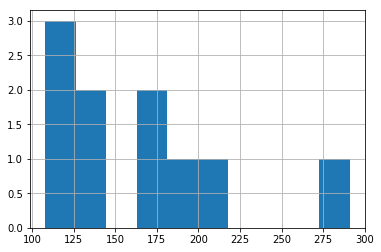

In [44]:
unknown_counts[unknown_counts['count'] > 100]['count'].hist()